In [2]:
import os

In [3]:
# use GPU 1
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
IMAGES_DIR = '/d2/caches/kaggle-planet/processed-images-64x64'
IMAGE_SHAPE = (64, 64, 4)
TEST_TIFFS_DIR = '/datasets/kaggle/planet/test-tif-v2'
MODEL = '/d2/caches/kaggle-planet/models/A/e14-l=0.21645-vl=0.53660.h5'
BATCH_SIZE = 128

In [5]:
%run 'Lib.ipynb'

In [6]:
import keras

Using TensorFlow backend.


In [7]:
X_files_pred = [x.split('.')[0] for x in list_files(TEST_TIFFS_DIR)]
print(len(X_files_pred))

61191


In [8]:
# number of batches for prediction
import math
N_BATCHES = int(math.ceil(float(len(X_files_pred)) / float(BATCH_SIZE)))

In [9]:
model = keras.models.load_model(MODEL)

In [10]:
# map actual files to csv provided

test_mapping = pd.read_csv('/datasets/kaggle/planet/test_v2_file_mapping.csv')
import re

def map_file_v2(orig):
    fid = re.findall('\\d+', orig)[0]
    d = test_mapping[test_mapping['old'] == ('file_' + fid + '.tif')]
    if len(d) == 0: fid_new = fid
    else: fid_new = re.findall('\\d+', d['new'].values[0])[0]
    return ('file_' + fid_new + '.tif', 'test_' + fid_new + '.jpg')

In [11]:
subm = []

import re

classes_misc = np.load('out/classes_misc.npy').tolist()
classes_weather = np.load('out/classes_weather.npy').tolist()

i = 0

for f in tqdm(X_files_pred):
    assert (os.path.isfile(IMAGES_DIR + '/' + f))

    b = generate_batch(
        n_samples=1,
        batch_index=i,
        X_files=X_files_pred,
        Y_tags_misc=None,
        Y_tags_weather=None,
        images_dir=IMAGES_DIR,
        image_shape=IMAGE_SHAPE)

    p = model.predict_on_batch(b)

    tags = []

    tags_misc = p[0][0]
    tags_weather = p[1][0]

    # misc
    for j, v in enumerate(tags_misc):
        if v > 0.5:  # cut-off
            tags.append(classes_misc[j])

    # weather
    tag_weather = classes_weather[np.argmax(tags_weather)]
    if 'unknown' != tag_weather: tags.append(tag_weather)

    #     print(f, tags, map_file_v2(f))

#     fid = re.findall('\\d+', f)[0]
    subm.append({'image_name': f, 'tags': ' '.join(tags)})

    i += 1

100%|██████████| 61191/61191 [01:34<00:00, 649.03it/s]


In [12]:
subm_df = pd.DataFrame(subm)

In [13]:
subm_df.to_csv('out/submission-a.csv', index=False)

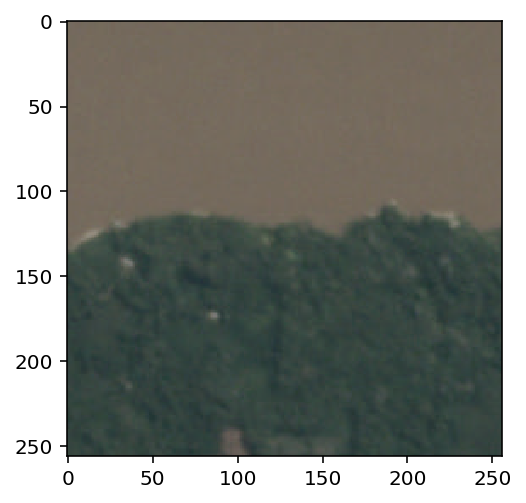

In [58]:
plt.imshow(plt.imread('/datasets/kaggle/planet/test-jpg/test_7110.jpg'))

In [21]:
len(X_files_pred)

61191

In [20]:
X_files_pred = [x.split('.')[0] for x in list_files(TEST_TIFFS_DIR)]

In [28]:
subm_df[subm_df['image_name'] == 'test_8163']

,image_name,tags
295,test_8163,agriculture habitation primary road clear
467,test_8163,agriculture primary road clear
61658,test_8163,agriculture primary road clear


In [27]:
for r in subm:
    if 'test_8163' == r['image_name']:
        print(r)

{'tags': 'agriculture habitation primary road clear', 'image_name': 'test_8163'}
{'tags': 'agriculture primary road clear', 'image_name': 'test_8163'}
{'tags': 'agriculture primary road clear', 'image_name': 'test_8163'}


In [13]:
import re

In [14]:
for f in X_files_pred:
    if '8163' in f:
        print(f)

file_8163
test_8163
test_28163
file_18163
test_38163
test_18163
